# Reinforcement Learning for Portfolio Allocation for Banking Sector Stocks


In the reinforcement learning based framework defined for this problem,  the algorithm determines the optimal portfolio allocation depending upon the current state of the portfolio of instruments. 

The algorithm is trained using Deep QLearning framework and the components of the reinforcement learning environment are:

* Agent: Portfolio manager, robo advisor or an individual.
* Action: Assignment and rebalancing the portfolio weights. The DQN model provides the Q-values which is further converted into portfolio weights.

* Reward function: Sharpe ratio, which consists of the standard deviation as the risk assessment measure is used reward function. 

* State: The state is the correlation matrix of the instruments based on a specific time window. The correlation matrix is a suitable state variable for the portfolio allocation, as it contains the information about the relationships between different instruments and can be useful in performing portfolio allocation.

* Environment: Cryptocurrency exchange.


The data of cryptocurrencies that we will be using for this case study is obtained from
the Kaggle platform and contains the daily prices of the cryptocurrencies during the
period of 2018. The data contains some of the most liquid cryptocurrencies such as
Bitcoin, Ethereum, Ripple, Litecoin and Dash.

In [ ]:
!python --version

Python 3.9.16


In [ ]:
#pip install pandas

In [ ]:
#pip install matplotlib

In [ ]:
#pip install seaborn

In [ ]:
#pip install sklearn

In [ ]:
#pip install numpy scipy scikit-learn

In [ ]:
#conda install openpyxl

In [ ]:
#conda install statsmodels

In [ ]:
#conda install numba

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
import time
from numpy.random import choice
import random

from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

import numpy as np
import pandas as pd

import random
from collections import deque
import matplotlib.pylab as plt

import tensorflow as tf

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:

#The data already obtained from yahoo finance is imported.
dataset = pd.read_excel('train_data_17_18.xlsx')

In [ ]:
# shape
dataset.shape

(439, 11)

In [ ]:
#dataset.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)

In [ ]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Date,HDFCBANK.NS,ICICIBANK.NS,HDFC.NS,KOTAKBANK.NS,AXISBANK.NS,SBIN.NS,BAJFINANCE.NS,BAJAJFINSV.NS,SBILIFE.NS,HDFCLIFE.NS
0,2017-11-17,912.775024,325.100006,1705.500000,1023.200012,542.400024,337.500000,1787.349976,512.974976,659.549988,344.600006
1,2017-11-20,919.075012,318.549988,1689.199951,1040.550049,545.150024,333.000000,1805.250000,517.354980,661.450012,355.350006
2,2017-11-21,923.125000,319.899994,1694.500000,1029.849976,546.799988,330.649994,1809.750000,520.619995,687.450012,385.299988
3,2017-11-22,927.625000,318.899994,1718.150024,1026.250000,540.500000,335.299988,1773.949951,517.635010,693.150024,395.200012
4,2017-11-23,921.424988,319.450012,1704.599976,1022.099976,544.150024,334.950012,1763.650024,513.359985,666.299988,374.850006


In [ ]:
dataset.columns

Index(['Date', 'HDFCBANK.NS', 'ICICIBANK.NS', 'HDFC.NS', 'KOTAKBANK.NS', 'AXISBANK.NS', 'SBIN.NS',
       'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'SBILIFE.NS', 'HDFCLIFE.NS'],
      dtype='object')

In [ ]:
dataset.isna().sum()

Date             0
HDFCBANK.NS      0
ICICIBANK.NS     0
HDFC.NS          0
KOTAKBANK.NS     0
AXISBANK.NS      0
SBIN.NS          0
BAJFINANCE.NS    0
BAJAJFINSV.NS    0
SBILIFE.NS       0
HDFCLIFE.NS      0
dtype: int64

We will look at the following Scripts :

1. Creating Environment 
2. Helper Functions
3. Training Agents


<a id='4.1'></a>
## Cryptocurrency environment

We introduce a simulation environment class “CryptoEnvironment”, where
we create a working environment for cryptocurrencies. This class has following key
functions:

* Function “getState: This function returns the state, which is the correlation matrix of
the instruments based on a lookback period. The function also returns the historical
return or raw historical data as the state depending on is_cov_matrix or
is_raw_time_series flag.
* Function “getReward: This function returns the reward, which is sharp ratio of the
portfolio, given the portfolio weight and lookback period.

In [ ]:
import numpy as np
import pandas as pd

from IPython.core.debugger import set_trace

#define a function portfolio
def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:
    def __init__(self, prices = 'train_data_17_18.xlsx', test_prices = "test_data_19.xlsx", capital = 1e6):       
        self.prices = prices  
        self.test_prices = test_prices
        self.capital = capital  
        self.data = self.load_data()
        self.test_data = self.load_test_data()

    def load_data(self):
        data =  pd.read_excel(self.prices)
        try:
            data.index = data['Date']
            data = data.drop(columns = ['Date'])
        except:
            data.index = data['date']
            data = data.drop(columns = ['date'])            
        return data
    
    def load_test_data(self):
        test_data = pd.read_excel(self.test_prices)
        try:
            test_data.index = test_data['Date']
            test_data = test_data.drop(columns = ['Date'])
        except:
            test_data.index = test_data['date']
            test_data = test_data.drop(columns = ['date'])            
        return test_data

    def preprocess_state(self, state):
        return state
    
    
    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        #set_trace()
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)
        
    
    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))          
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns, weights), sharpe
        


<a id='4.2'></a>
## Agent Script

In this section, we will train an agent that will perform reinforcement learning based on the actor and critic networks. We will perform the following steps to achieve this:
* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
* Create a Replay function that adds, samples, and evaluates a buffer.
* Add a new experience to the replay buffer memory
* Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. We do this so that the states that we feed to the model are not temporally correlated. This will reduce overfitting:
* Return the current size of the buffer memory
* The number of actions are defined as 3: sit, buy, sell
* Define the replay memory size
* Reward function is return 


In [ ]:
class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    
    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    #return the action based on the state, uses the NN function 
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    
    def expReplay(self, batch_size):

        
        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            #Reward =reward if not in the terminal state. 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

<a id='4.3'></a>
## Training the data

jjje train the algorithm. In order to do that, we first initialize the “Agent” class and “CryptoEnvironment” class. 

In [ ]:
N_ASSETS = 10 #53
agent = Agent(N_ASSETS)
env = CryptoEnvironment()

In [ ]:
window_size = 90
episode_count = 50
batch_size = 32
rebalance_period = 45 #every 90 days weight change

In [ ]:
from itertools import product

window_size = [55] #[30,60,90]
episode_count = [500]
batch_size = [32] #[16, 32, 64, 128]
rebalance_period = [50] #[30, 45, 60]

permutations = list(product(window_size, episode_count, batch_size, rebalance_period))
permutations

[(55, 500, 32, 50)]

In [ ]:
for window_size,episode_count,batch_size,rebalance_period in permutations:
  print(window_size,episode_count,batch_size,rebalance_period)

55 500 32 50


In [ ]:
data_length = len(env.data)
data_length

439

In [ ]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [ ]:
from timeit import default_timer as timer
start = timer()
#i=0
#res_df = pd.DataFrame({'Window_Size': [], 'Episode': [], 'Batch Size': [], 'Rebalancing Period': [],'Returns': [], 'Volatility': [], 'Sharpe Ratio': [], 'Alpha': [], 'Beta': []})
for window_size,episode_count,batch_size,rebalance_period in permutations:
    
    for e in range(episode_count):
        agent.is_eval = False
        data_length = len(env.data)
        returns_history = []
        returns_history_equal = []
      
        rewards_history = []
        equal_rewards = []
      
        actions_to_show = []
      
        print("Episode " + str(e+1) + "/" + str(episode_count), 'epsilon', agent.epsilon)

        s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
        total_profit = 0
      
        
        for t in range(window_size, data_length, rebalance_period):
            date1 = t-rebalance_period
          #correlation from 90-180 days 
            s_ = env.get_state(t, window_size)
            action = agent.act(s_)
          
            actions_to_show.append(action[0])
          
            weighted_returns, reward = env.get_reward(action[0], date1, t)
            weighted_returns_equal, reward_equal = env.get_reward(np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

            rewards_history.append(reward)
            equal_rewards.append(reward_equal)
            returns_history.extend(weighted_returns)
            returns_history_equal.extend(weighted_returns_equal)

            done = True if t == data_length else False
            agent.memory4replay.append((s, s_, action, reward, done))
          
            if len(agent.memory4replay) >= batch_size:
                agent.expReplay(batch_size)
                agent.memory4replay = []
              
            s = s_
          #print(action[0])

'''
        rl_result = np.array(returns_history).cumsum()
        equal_result = np.array(returns_history_equal).cumsum()
    
        plt.figure(figsize = (12, 2))
        plt.plot(rl_result, color = 'black', ls = '-')
        plt.plot(equal_result, color = 'grey', ls = '--')
        plt.show()
      
        plt.figure(figsize = (12, 2))
        for a in actions_to_show:    
            plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
            plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
        plt.show()
      
  
  agent.is_eval = True

  actions_equal, actions_rl = [], []
  result_equal, result_rl = [], []

  for t in range(window_size, len(env.data), rebalance_period):

      date1 = t-rebalance_period
      s_ = env.get_state(t, window_size)
      action = agent.act(s_)
      #print(action)
      weighted_returns, reward = env.get_reward(action[0], date1, t)
      weighted_returns_equal, reward_equal = env.get_reward(
          np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

      result_equal.append(weighted_returns_equal.tolist())
      actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
      
      result_rl.append(weighted_returns.tolist())
      actions_rl.append(action[0])

  result_equal_vis = [item for sublist in result_equal for item in sublist]
  result_rl_vis = [item for sublist in result_rl for item in sublist]

  plt.figure()
  plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
  plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
  plt.show()

  print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
  l = print_stats(result_rl_vis, result_equal_vis)
  print('RL AGENT', l)
  #if res_df.empty:
    #l = print_stats(result_rl_vis, result_equal_vis)
    #res_df = pd.DataFrame({'Returns': list(l[0]), 'Volatility': list(l[1]), 'Sharpe Ratio': list(l[2]), 'Alpha': list(l[3]), 'Beta': list(l[4])}) 
  #else:
  #res_df.loc[len(res_df.index)] = list(permutations[i])+l
  #i += 1
#res_df[['Window_Size','Episode','Batch Size','Rebalancing Period']] = res_df[['Window_Size','Episode','Batch Size','Rebalancing Period']].astype(int)
'''
print("with GPU:", timer()-start)

Episode 1/500 epsilon 1
Episode 2/500 epsilon 1
Episode 3/500 epsilon 1
Episode 4/500 epsilon 1
Episode 5/500 epsilon 0.99
Episode 6/500 epsilon 0.99
Episode 7/500 epsilon 0.99
Episode 8/500 epsilon 0.99
Episode 9/500 epsilon 0.9801
Episode 10/500 epsilon 0.9801
Episode 11/500 epsilon 0.9801
Episode 12/500 epsilon 0.9801
Episode 13/500 epsilon 0.9702989999999999
Episode 14/500 epsilon 0.9702989999999999
Episode 15/500 epsilon 0.9702989999999999
Episode 16/500 epsilon 0.9702989999999999
Episode 17/500 epsilon 0.96059601
Episode 18/500 epsilon 0.96059601
Episode 19/500 epsilon 0.96059601
Episode 20/500 epsilon 0.96059601
Episode 21/500 epsilon 0.9509900498999999
Episode 22/500 epsilon 0.9509900498999999
Episode 23/500 epsilon 0.9509900498999999
Episode 24/500 epsilon 0.9509900498999999
Episode 25/500 epsilon 0.9414801494009999
Episode 26/500 epsilon 0.9414801494009999
Episode 27/500 epsilon 0.9414801494009999
Episode 28/500 epsilon 0.9414801494009999
Episode 29/500 epsilon 0.932065347906

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from numba import vectorize,float64

from numba import njit,guvectorize

import numpy as np

from time import perf_counter

def timer(f,*args):
    start = perf_counter()
    f(*args)
    return 1000 * (perf_counter() - start)

def native_f(x, y):
    return x**2 + y**2

@njit
def njit_f(x, y):
    return x**2 + y**2

# It is preferable to give type signatures
# In this function 2 float64 are taken as inputs and returning a float 64 as output 
# Output Type (Input 1 type, Input 2 type)
# always add nopython=True explicitly
@vectorize([float64(float64, float64)],nopython=True)
def vector_f(x, y):
    return x**2 + y**2

# float64[:] : array of float 64
# '(n),(n)->(n)' => your inputs are 2 n dimensional array  and output is n dimensional array 
# In this case numba is able to infer the correct data type even though I am using this function on 2 d array
# correct representation : [(float64[:,:], float64[:,:], float64[:,:])], '(n,n),(n,n)->(n,n)'
@guvectorize([(float64[:], float64[:], float64[:])], '(n),(n)->(n)',nopython=True)
def gu_vector_f(x, y, z):
# it takes z as a input variable and fills it up
# it returns nothing
    z =  x**2 + y**2            

row = 1000
col = 1000

a = np.random.rand(row,col)
b = np.random.rand(row,col)

num_freq = 100

print(1000 * np.mean([timer(native_f,a,b) for _ in range(num_freq)]))

print(1000 * np.mean([timer(njit_f,a,b) for _ in range(num_freq)]))

print(1000 * np.mean([timer(vector_f,a,b) for _ in range(num_freq)]))

print(1000 * np.mean([timer(gu_vector_f,a,b) for _ in range(num_freq)]))

12507.872999988194
11799.729999997908
3869.6169999911945
1759.608999991542


In [ ]:
from numba import jit, cuda
import numpy as np
# to measure exec time
from timeit import default_timer as timer

# normal function to run on cpu
def func(a):								
	for i in range(9999999):
		a[i]+= 1	

# function optimized to run on gpu
@jit(target_backend='cuda')						
def func2(a):
	for i in range(9999999):
		a[i]+= 1
if __name__=="__main__":
	n = 10000000							
	a = np.ones(n, dtype = np.float64)
	
	start = timer()
	func(a)
	print("without GPU:", timer()-start)	
	
	start = timer()
	func2(a)
	print("with GPU:", timer()-start)


without GPU: 4.050085300000092
with GPU: 0.09995720000006258


In [ ]:
np.__version__

'1.23.5'

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10945436746252645081
]


In [ ]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())
#['/device:CPU:0','/device:GPU:0']

['/device:CPU:0']


The charts shown above show the details of the portfolio allocation of all the episodes.

<a id='5'></a>
## Testing the Data 

In [ ]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.test_data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

print(list(action[0]))

[0.09845934734774428, 0.09530390909237481, 0.09596520764921823, 0.10398936933609257, -0.10702996940380903, -0.10595838765752075, 0.10851965837713906, 0.09218999662460897, 0.09211380373310603, 0.10047035077838626]


In [ ]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

In [ ]:
result_equal_vis2 = [item for sublist in result_equal for item in sublist]
result_rl_vis2 = [item for sublist in result_rl for item in sublist]

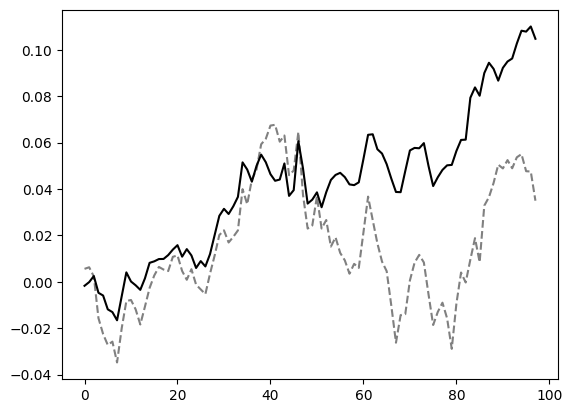

In [ ]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

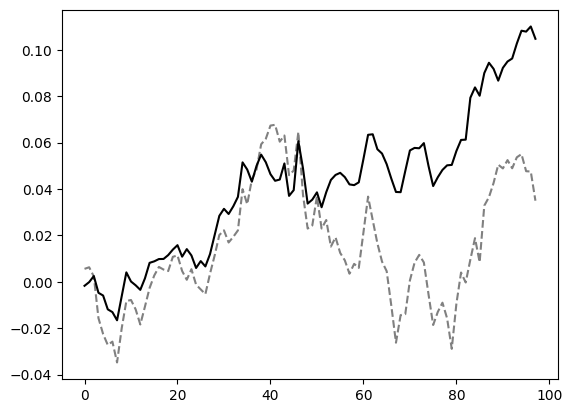

In [ ]:
plt.figure()
plt.plot(np.array(result_equal_vis2).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis2).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

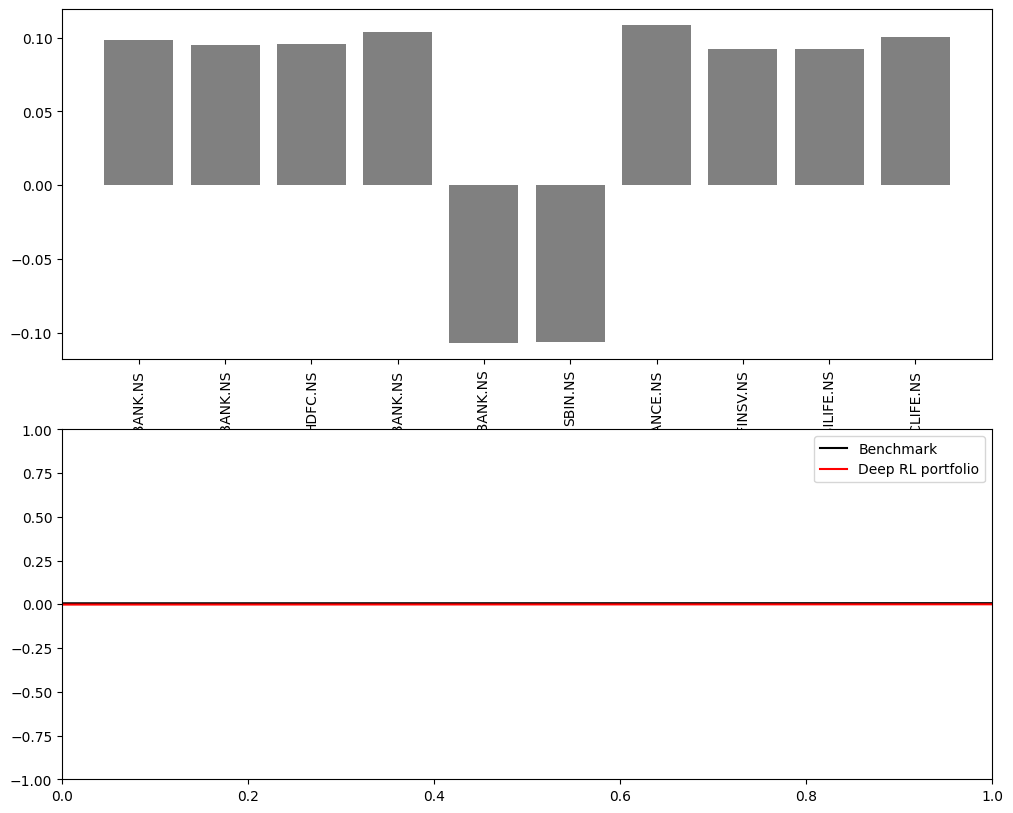

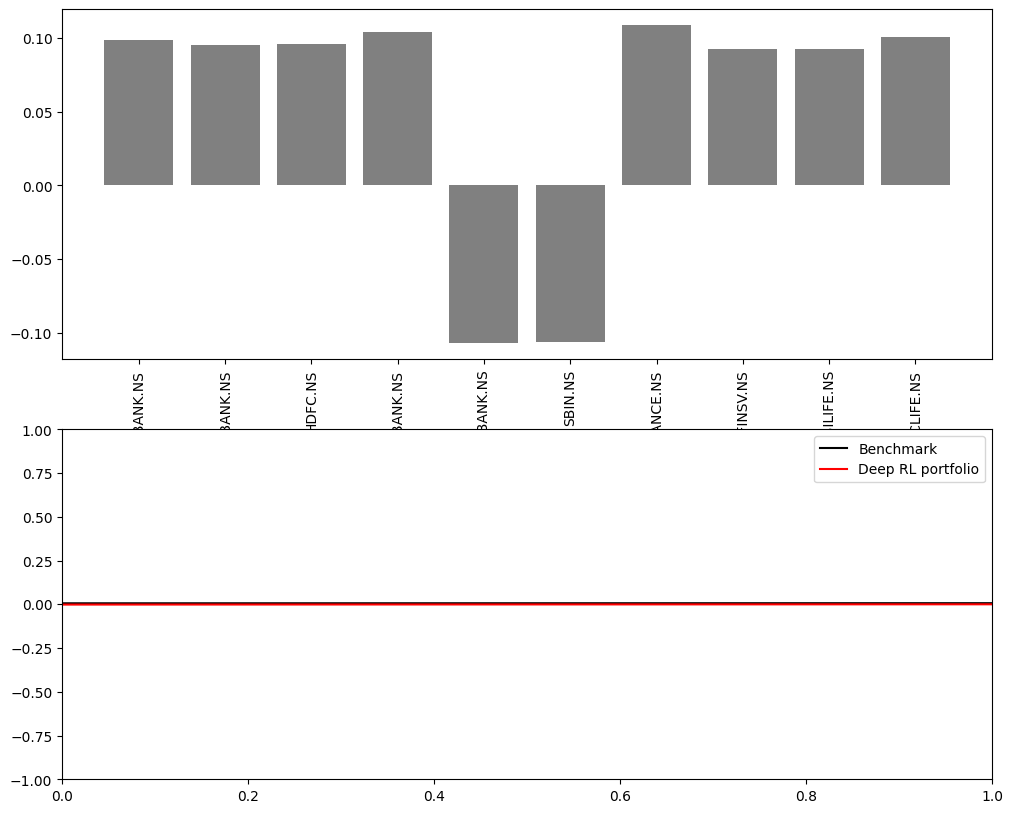

In [ ]:
#Plotting the data
import matplotlib
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum()) 

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.colormaps = current_cmap
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()

In [ ]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [ ]:
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

EQUAL [0.0004, 0.0093, 0.5142, -0.0, 1.0]
RL AGENT [0.0011, 0.0061, 2.8555, 0.0009, 0.4798]


In [ ]:
print('EQUAL', print_stats(result_equal_vis2, result_equal_vis2))
print('RL AGENT', print_stats(result_rl_vis2, result_equal_vis2))

EQUAL [0.0004, 0.0093, 0.5142, -0.0, 1.0]
RL AGENT [0.0011, 0.0061, 2.8555, 0.0009, 0.4798]


**RL** portfolio has a higher return, higher sharp, lower volatility, higher alpha and negative correlation with the benchmark. 

**Conclusion**

The idea in this case study was to go beyond classical Markowitz efficient frontier and directly learn the policy of changing the weights dynamically in the continuously
changing market. 

We set up a standardized working environ‐
ment(“gym”) for cryptocurrencies to facilitate the training. The model starts to learn over a period of time, discovers the strategy
and starts to exploit it. we used the testing set to evaluate the model and found an
overall profit in the test set.

Overall, the framework provided in this case study can enable financial practitioners
to perform portfolio allocation and rebalancing with a very flexible and automated
approach and can prove to be immensely useful, specifically for robo-advisors
